# Second Order Effect

In [1]:
import sys
import utils_1 as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
reload(utils)

C:\Users\muham\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<module 'utils_1' from 'D:\\(Akademik)\\(CDT in Mathematics of Random Systems)\\[Broker, Informed, Noise Traders, Filtering Game]\\utils_1.py'>

In [2]:
%load_ext autoreload
%autoreload 2
np.random.seed(100)

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')

In [4]:
font1 = 16 #25
font2 = 20

## 1. Choose the signal filtering strategy & benchmark

In [5]:
# choosing strategy type
# available strategies are "our model", "alternative filter", "naive filter"
# mispecify parameter represents whether the broker mispecifies the informed trader's inventory or not

strategy_type = "our model"
mispecify = False
file_name = f'{strategy_type}'
if mispecify:
    file_name += f' (mispecified inventory)'
    
alpha_est_name = {"our model": r'$\hat{\alpha}_t$',
                  "alternative filter": r'$\hat{\alpha}^{alt}_t$',
                  "naive filter": r'$\hat{\alpha}^{naive}_t$'}

## 2. Set the parameters & functions involved

In [6]:
params_env = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': 5., 'sigma_alpha': 1, 
              'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

env = utils.environment(**params_env)

params_uninf = {'kappa' : 15., 'nu0' : 0., 'sigma' : 100., 'k' : 2e-03}

uninf_trader = utils.uninformed(**params_uninf)

scale_ivp = 100000 # change this to change the scale in solving ivp for V_B

nsims = 10_000

W = env.simulate_BM_with_drift(x0=0, mu=0, sigma=1, nsims=nsims)
alpha = env.simulate_alpha(nsims = nsims)
nu_U = uninf_trader.simulate_uninformed_flow(env, nsims=nsims)

c_importance = [0, 1]

In [7]:
c_importance

[0, 1]

## 4. Simulate the informed trader & broker's strategies

In [8]:
import simulations_1 as simulations

In [9]:
sim_collections = []
inf_trader_collections = []
broker_collections = []

In [10]:
for c in c_importance:

    scale_ivp = 100000 # change this to change the scale in solving ivp for V_B

    params_inf = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-5, 'beta1' : 1e-3, 'rho0' : 1e-3, 'rho1' : 1e-5,
                      'sigma_B' : 60., 'mu_B' : 0., 'theta_B' : 10., 'sigma_0' : 0, 'c_importance' : c}

    inf_trader =  utils.informed(**params_inf)
    
    inf_trader_collections.append(inf_trader)

    params_broker = {'env': env, 'inf': inf_trader, 'uninf': uninf_trader,
                     'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-5, 'beta1': 1e-3, 'rho0': 1e-3, 'rho1': 1e-5, 
                     'sigma_B': inf_trader.sigma_B, 'mu_B': inf_trader.mu_B, 'theta_B': inf_trader.theta_B, 
                     'sigma_0': 0, 'scale_ivp': scale_ivp}

    broker = utils.broker(**params_broker)
    
    broker_collections.append(broker)

    model = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                   W, alpha, nu_U, 
                                   strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)
    
    sim_collections.append(model)

## 5. Plot the results

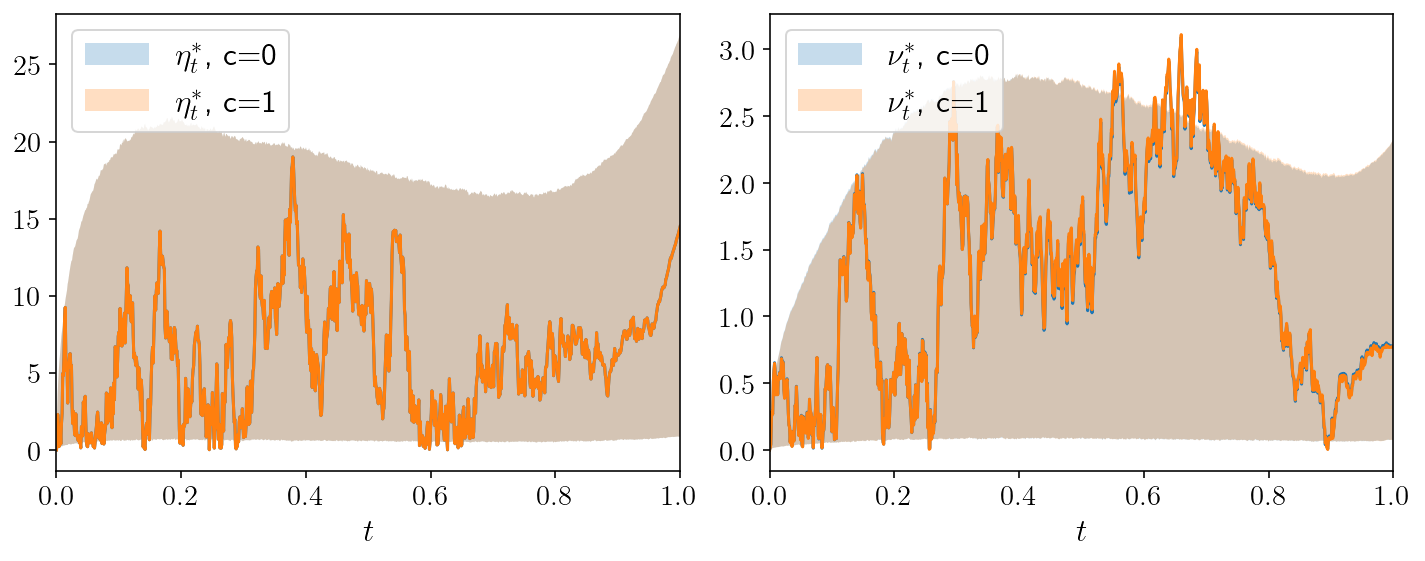

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
t = env.timesteps

for i, c in enumerate(c_importance):
    qtl_nu_I = np.quantile(np.abs(sim_collections[i].nu_I),[0.05,0.5,0.95], axis=1)
    qtl_nu_B = np.quantile(np.abs(sim_collections[i].nu_B),[0.05,0.5,0.95], axis=1)
    
    ax[0].fill_between(t,qtl_nu_I[0],qtl_nu_I[-1],alpha=0.25, label=r'$\eta_t^*$' + f', c={c}')
    ax[1].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$\nu_t^*$' + f', c={c}')
    ax[0].plot(t, np.abs(sim_collections[i].nu_I[:,1]), markevery=100)
    ax[1].plot(t, np.abs(sim_collections[i].nu_B[:,1]), markevery=100)
    ax[0].set_xlabel(r'$t$',fontsize=16)
    ax[0].legend(fontsize=16,loc='upper left')
    
    ax[1].set_xlabel(r'$t$',fontsize=16)
    ax[1].legend(fontsize=16,loc='upper left')
    
    ax[0].set_xlim(0.,1)
    ax[1].set_xlim(0.,1)

plt.tight_layout()
plt.show()

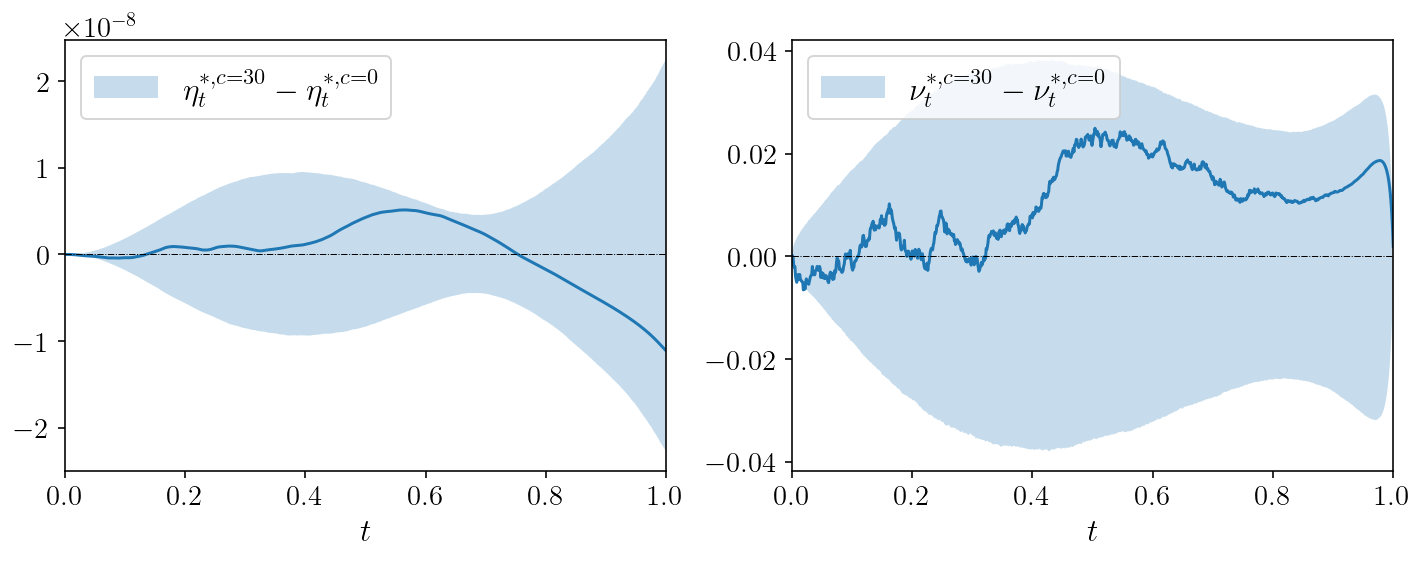

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
t = env.timesteps

nu_I_diff_abs = (sim_collections[1].nu_I) - (sim_collections[0].nu_I)
nu_B_diff_abs = (sim_collections[1].nu_B) - (sim_collections[0].nu_B)

qtl_nu_I = np.quantile(nu_I_diff_abs,[0.05,0.5,0.95], axis=1)
qtl_nu_B = np.quantile(nu_B_diff_abs,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,qtl_nu_I[0],qtl_nu_I[-1],alpha=0.25, label=r'$\eta_t^{*,c=30} - \eta_t^{*,c=0}$')
ax[1].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$\nu_t^{*,c=30} - \nu_t^{*,c=0}$')
ax[0].plot(t, nu_I_diff_abs[:,1], markevery=100)
ax[1].plot(t, nu_B_diff_abs[:,1], markevery=100)
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')

ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper left')

ax[0].set_xlim(0.,1)
ax[1].set_xlim(0.,1)

ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.show()

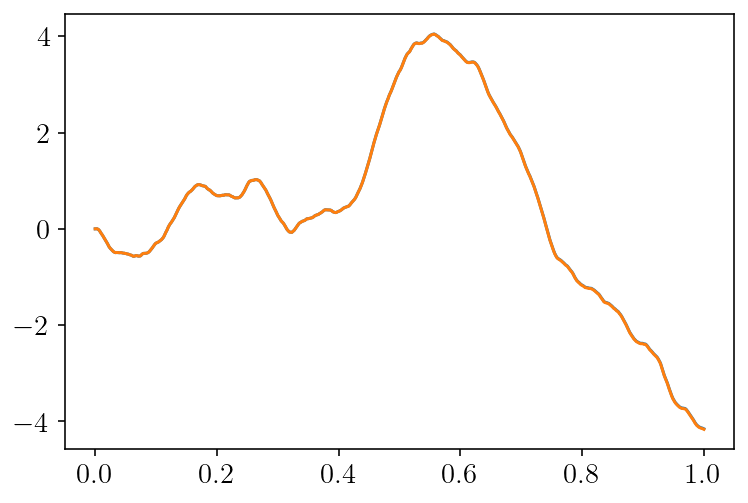

In [13]:
plt.plot(t, sim_collections[1].Q_B[:,1])
plt.plot(t, sim_collections[0].Q_B[:,1])

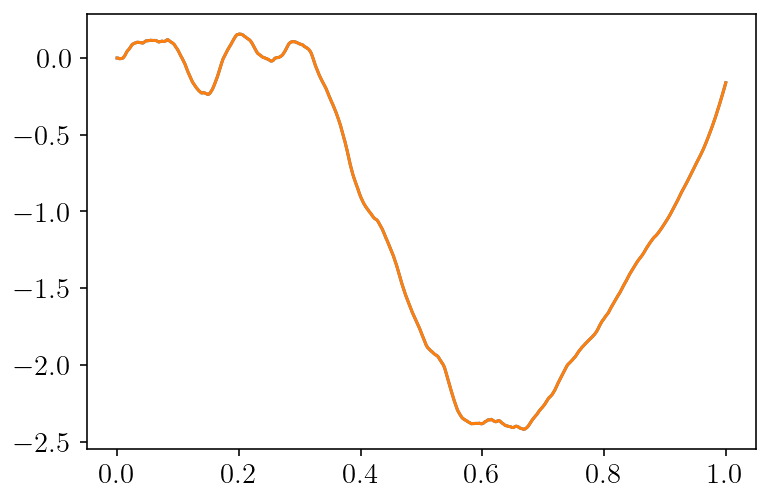

In [14]:
plt.plot(t, sim_collections[1].Q_I[:,1])
plt.plot(t, sim_collections[0].Q_I[:,1])

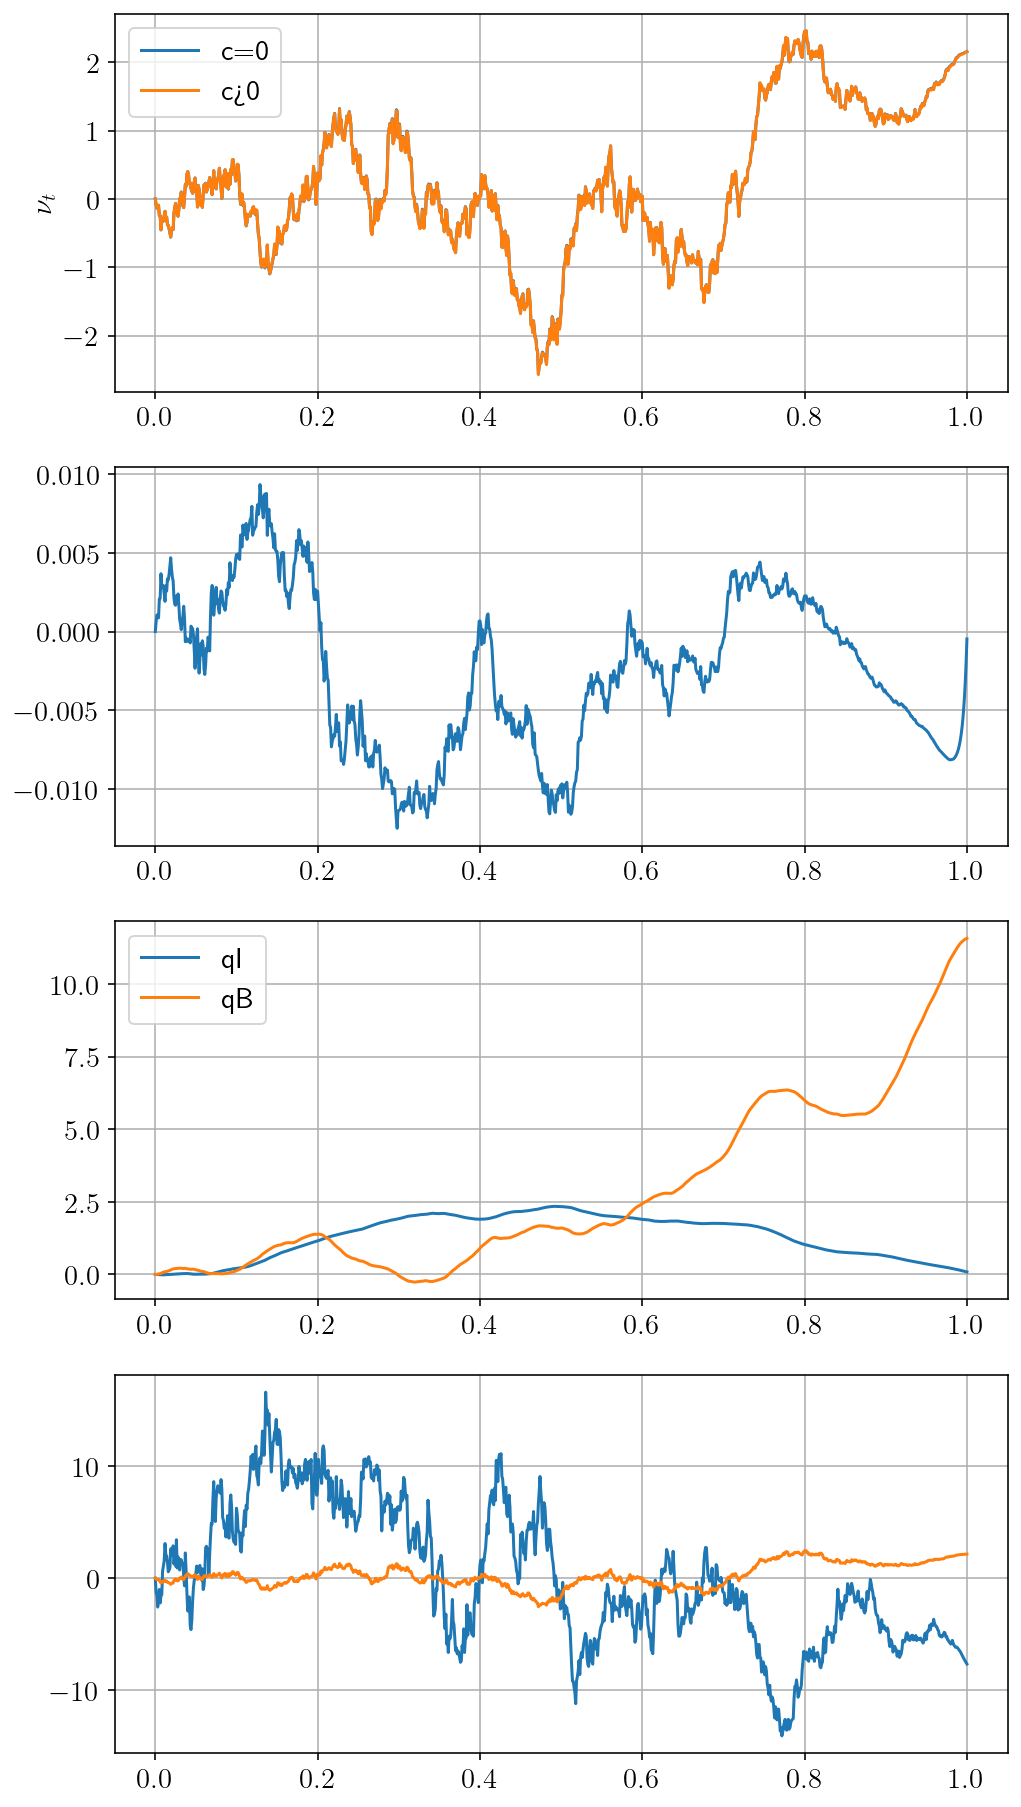

In [15]:
qtl_alpha = np.quantile(alpha,[0.05,0.5,0.95], axis=1)
qtl_nu_U = np.quantile(nu_U,[0.05,0.5,0.95], axis=1)
iseed=10
t = env.timesteps

font1 = 25
font2 = 23
fig, ax = plt.subplots(4,1,figsize=(8, 16))

t = env.timesteps

nu_I_diff = (sim_collections[1].nu_I) - (sim_collections[0].nu_I)
nu_B_diff = (sim_collections[1].nu_B) - (sim_collections[0].nu_B)

qtl_nu_I_diff = np.quantile(nu_I_diff,[0.05,0.5,0.95], axis=1)
qtl_nu_B_diff = np.quantile(nu_B_diff,[0.05,0.5,0.95], axis=1)

qtl_alpha = np.quantile(alpha,[0.05,0.5,0.95], axis=1)
qtl_nu_U = np.quantile(nu_U,[0.05,0.5,0.95], axis=1)

ax[0].plot(t, sim_collections[0].nu_B[:,iseed])
ax[0].plot(t, sim_collections[1].nu_B[:,iseed])
ax[0].legend(['c=0','c>0'])
ax[0].set_ylabel(r'$\nu_t$')
ax[1].plot(t, nu_B_diff[:,iseed], markevery=100)
ax[2].plot(t, sim_collections[1].Q_I[:,iseed])
ax[2].plot(t, sim_collections[1].Q_B[:,iseed])
ax[2].legend(['qI','qB']); 
ax[3].plot(t, sim_collections[1].nu_I[:,iseed])
ax[3].plot(t, sim_collections[1].nu_B[:,iseed])
#.plot(t, alpha[:,1], markevery=100,color='tab:green')
for a in ax: a.grid()
plt.show()

In [16]:
Q_B_0 = sim_collections[0].Q_B
Q_B_1 = sim_collections[1].Q_B

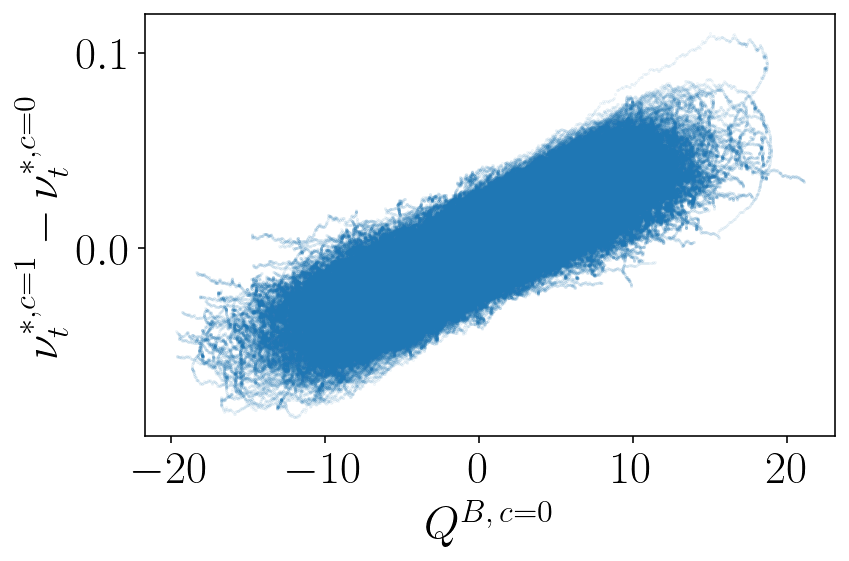

In [27]:
t_idx = 750

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.scatter(np.ndarray.flatten(Q_B_0[:t_idx,:]), np.ndarray.flatten(nu_B_diff[:t_idx,:]),s=.1,alpha=0.1)

ax.set_xlabel(r'$Q^{B,\, c = 0}$', fontsize = font2)
ax.tick_params(axis='both', which='major', labelsize=font2)
ax.set_ylabel(r'$\nu_t^{*, c=1} - \nu_t^{*, c=0}$', fontsize = font2)

plt.tight_layout()
plt.savefig('figures/second_order_effect_broker_new.png', format="png", dpi=300)

plt.show()

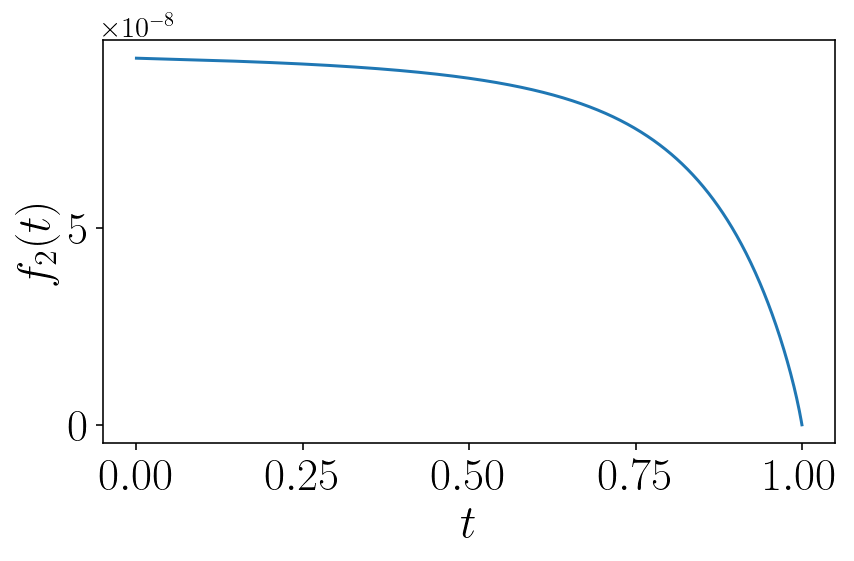

In [21]:
z = inf_trader.z
f2 = z[2] / 2*inf_trader.k

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(env.timesteps, f2)

ax.set_xlabel(r'$t$', fontsize = font2)
ax.tick_params(axis='both', which='major', labelsize=font2)
ax.set_ylabel(r'$f_2(t)$', fontsize = font2)

plt.tight_layout()
plt.savefig('figures/second_order_effect_broker_f2.pdf', format="pdf", dpi=100)

plt.show()

In [ ]:
plt.scatter(np.ndarray.flatten(Q_B_1[:t_idx,:]), np.ndarray.flatten(nu_B_diff[:t_idx,:]),s=.1,alpha=0.1)
plt.show()

In [ ]:
coef_var = broker_collections[1].coef_speed_B[:, 0, 3]
var_name_qtl = np.quantile(nu_U,[0.05,0.5,0.95], axis=1)

nu_B_var = ((coef_var.reshape((-1,1)))@np.ones(shape=(1,nsims)))*nu_U
nu_B_var_qtl = np.quantile(nu_B_var,[0.05,0.5,0.95], axis=1)

fig, ax = plt.subplots()

ax.fill_between(t,nu_B_var_qtl[0],nu_B_var_qtl[-1],alpha=0.25)
ax.plot(t, nu_B_var[:,iseed])
ax.set_xlabel(r'$t$',fontsize=16)
ax.legend(fontsize=16,loc='upper left')
ax.set_xlim(0,1)
ax.axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(broker_collections[1].coef_speed_B[:, 0, 3])